In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from keras.utils import plot_model
import math
from keras.optimizers import RMSprop
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-02-01 15:05:01.427248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:05:01.580187: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 15:05:02.548797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-01 15:05:02.548901

In [2]:
adv_model = tf.keras.models.load_model('adversarial_model') # load the pre-trained adversarial-generalization model 
org_aug_model = tf.keras.models.load_model('initial_augmented_model') # load the original model
adv_aug_model = tf.keras.models.load_model('adversarial_augmented_model') # load the original model

2023-02-01 15:05:12.554715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6690 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-02-01 15:05:12.555517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:1c:00.0, compute capability: 8.6
2023-02-01 15:05:12.556341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10092 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:1d:00.0, compute capability: 8.6
2023-02-01 15:05:12.557155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10092 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:1e:00.0, compute capability: 8.6
2023

### 1. CREATING ADVERSARIAL PATTERN FROM THE PREDICTED

In [3]:
loss_object = tf.keras.losses.CategoricalCrossentropy() # Cross-entropy loss in tf.keras


def create_adversarial_pattern(input_image, input_label, model):
    '''
    Create Adversarial pattern based on the model and input image.
    @param imput image: the original image
    @param input_label: the label of the original image 
    @param model: model used to predict the image 
    @return sign of the gradient of the image 
    '''
    with tf.GradientTape() as tape: # open gradient tape for automatic differentiation
        tape.watch(input_image) # start tracing the tensor 
        prediction = model(input_image) # return the model's prediction of the image
        loss = loss_object(input_label, prediction) # calculate the loss 

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image) 
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad



### 2. Load the test dataset

In [4]:
test_dataset = pd.read_csv("fashion-mnist_test.csv") # read data

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

def data_preprocessing(raw):
    '''
    Preprocess the data 
    @param raw: raw data, with col 0 = label and col 1->785 = image 
    @return image: the processed image  
    @return label: the label of the processed image 
    '''
    label = tf.keras.utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    image = x_shaped_array / 255
    return image, label

X, y = data_preprocessing(test_dataset) #preprocess data and reshape 

X_img = X.reshape(X.shape[0], 28, 28)




### 3. Create prediction and extract one-hot label from the prediction. Convert to tensor. 

In [5]:
y_pred_adv = adv_model.predict(X_img) #get the full prediction of the model 
y_pred_augo = org_aug_model.predict(X_img)
y_pred_augm = adv_aug_model.predict(X_img)

2023-02-01 15:05:19.383355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400


 34/313 [==>...........................] - ETA: 1s

2023-02-01 15:05:23.352079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 2s 5ms/step


In [6]:
label_adv = tf.one_hot(0, y_pred_adv.shape[-1])
label_adv = tf.reshape(label_adv, (1, y_pred_adv.shape[-1]))


label_aug_org =  tf.one_hot(0, y_pred_augo.shape[-1])
label_aug_org = tf.reshape(label_adv, (1, y_pred_augo.shape[-1]))

label_aug_adv =  tf.one_hot(0, y_pred_augm.shape[-1])
label_aug_adv = tf.reshape(label_adv, (1, y_pred_augm.shape[-1]))

In [7]:
## RESHAPE THE TEST SET AND CONVERT TO TENSOR 

X_img_reshape = []
for im in X_img:
    im_res = im.reshape(1, 28, 28, 1)
    im_ten = tf.convert_to_tensor(im_res)
    X_img_reshape.append(im_ten)

### 4. Generate perturbated examples from the test set. 

In [ ]:
#add perturbations to images
X_im_perturbate_adv_dict = {}
X_im_perturbate_augo_dict = {}
X_im_perturbate_augadv_dict = {}


epsilons = [0.05, 0.1, 0.15, 0.2]

i = 0
for eps in epsilons: 
    print('starting with ', eps)
    X_im_perturbate_adv_dict[eps] = []
    X_im_perturbate_augo_dict[eps] = []
    X_im_perturbate_augadv_dict[eps] = []
    for im in X_img_reshape:
        #for adversarial model: 
        perturbations_adv = create_adversarial_pattern(im, label_adv, adv_model)
        adv_x_adv = im + eps*perturbations_adv
        adv_x_adv = tf.clip_by_value(adv_x_adv, -1, 1).numpy()
        X_im_perturbate_adv_dict[eps].append(adv_x_adv)
        
        # for augmented original model
        perturbations_augo = create_adversarial_pattern(im, label_aug_org, org_aug_model)
        adv_x_augo = im + eps*perturbations_augo
        adv_x_augo = tf.clip_by_value(adv_x_augo, -1, 1).numpy()
        X_im_perturbate_augo_dict[eps].append(adv_x_augo)
        
        perturbations_augadv = create_adversarial_pattern(im, label_aug_adv, adv_aug_model)
        adv_x_augm = im + eps*perturbations_augadv
        adv_x_augm = tf.clip_by_value(adv_x_augm, -1, 1).numpy()
        X_im_perturbate_augadv_dict[eps].append(adv_x_augm)
        i += 1
        if i % 1000 == 0: 
            print('now at ', i)
    

### 5. Extract the data and plot the results.

In [ ]:
loss_ov_org = [0.4237, 1.053, 4.629, 10.5867, 17.5026, 24.8258]
acc_ov_org = [0.9227, 0.8329, 0.6360, 0.4866, 0.3896, 0.3272]
loss_org = []
acc_org = []



for eps in epsilons: 
    img_new = np.concatenate(X_im_perturbate_augo_dict[eps], axis=0)
    score = org_model.evaluate(img_new, y, steps=math.ceil(10000/32))
    loss_aug_org.append(score[0])
    acc_aug_org.append(score[1])




loss_aug_org = []
acc_aug_org = []


for eps in epsilons: 
    img_new = np.concatenate(X_im_perturbate_augo_dict[eps], axis=0)
    score = org_aug_model.evaluate(img_new, y, steps=math.ceil(10000/32))
    loss_aug_org.append(score[0])
    acc_aug_org.append(score[1])


In [ ]:
loss_adv = []
acc_adv = []
for eps in epsilons: 
    img_new = np.concatenate(X_im_perturbate_adv_dict[eps], axis=0)
    score = adv_model.evaluate(img_new, y, steps=math.ceil(10000/32))
    loss_adv.append(score[0])
    acc_adv.append(score[1])
    
loss_advm = []
acc_advm = []

for eps in epsilons: 
    img_new = np.concatenate(X_im_perturbate_augadv_dict[eps], axis=0)
    score = adv_aug_model.evaluate(img_new, y, steps=math.ceil(10000/32))
    loss_advm.append(score[0])
    print(X_im_perturbate_org_dict)


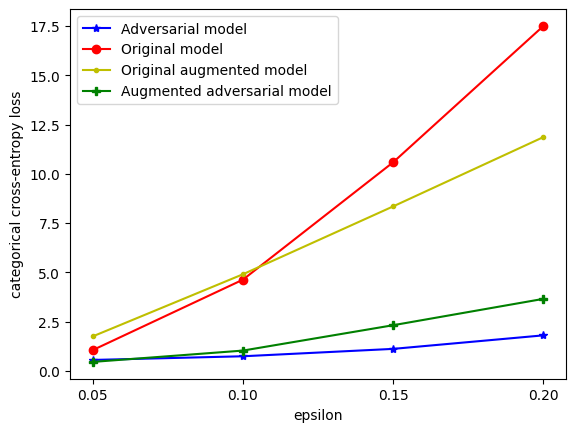

In [39]:
import matplotlib.pyplot as plt 

plt.plot(epsilons, loss_adv, marker="*", color='b', label="Adversarial model")
plt.plot(epsilons, loss_org, marker="o", color='r', label="Original model")
plt.plot(epsilons, loss_aug_org, marker=".", color='y', label="Original augmented model")
plt.plot(epsilons, loss_advm, marker="P", color='g', label= "Augmented adversarial model")
plt.xlabel('epsilon') 
plt.ylabel('categorical cross-entropy loss') 
plt.xticks(epsilons)
plt.legend()


([<matplotlib.axis.XTick at 0x7f2fbc0a95b0>,
 [Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15, 0, '0.15'),
  Text(0.2, 0, '0.20')])

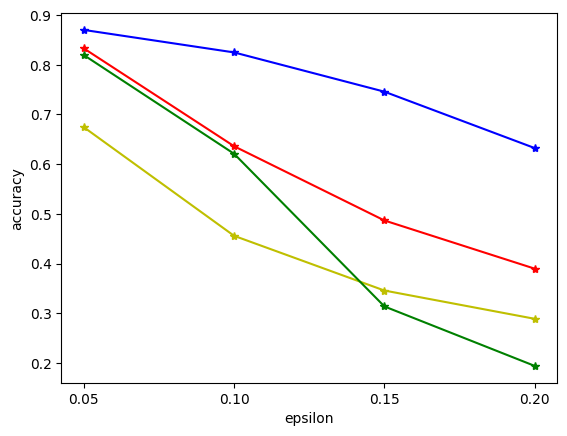

In [24]:
plt.plot(epsilons, acc_adv, marker="*", color='b', label="Adversarial model")
plt.plot(epsilons, acc_org, marker="*", color='r', label="Original model")
plt.plot(epsilons, acc_aug_org, marker="*", color='y', label="Original augmented model")
plt.plot(epsilons, acc_advm, marker="*", color='g', label= "Augmented adversarial model")
plt.xlabel('epsilon') 
plt.ylabel('accuracy') 
plt.xticks(epsilons)


#plt.legend()

